In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
%matplotlib inline


In [28]:
# before getting into modeling, we need to do some feature engineering. Looking at 
# the relationship between different features and the labels

# splitting the whole dataset into 7:2:1
# with different parameter combinations, train the classifier on 70% of the data
# get the performance metrics on the 20% of the data
# perform a grid search for the optimal combination of parameters for the classifiers
# once found the best combination of parameters, use them to train model on 90% of the data
# fit on the rest 10% and calculate the test metrics. 

In [29]:
final = pd.read_csv("final.csv", 
                             names = ['case' ,'platform', 'customer_id', 'timeStamp',
                                      'matched_payment_complete', 'label', 'name', 'email', 'gender', 'age',
                                      'home_type', 'square_footage', 'number_of_bedrooms', 'number_of_floors',
                                      'household', 'platform_y', 'street', 'suburb'])

final['times_denid']=final.groupby('customer_id')['label'].cumsum()

# final["first_half_email"] = final.email.map(lambda x: x.split("@")[0])
# final["name_in_email"] = 1*(final['first_half_email'] == final["name"])
# del final['first_half_email']

final.head()

,case,platform,customer_id,timeStamp,matched_payment_complete,label,name,email,gender,age,home_type,square_footage,number_of_bedrooms,number_of_floors,household,platform_y,street,suburb,times_denid
0,90527688b31d445,mobile_browser,99ccf1,1.483194e+09,1,1,Nicole Berry,Nicole Berry@hotmail.com,male,29,1,311.803620,2,1,"[{'name': 'Oscar Berry', 'age': 25, 'gender': ...",mobile_browser,66 Lake Jamieview,PSC,1
1,4c9ab2942b484f2,pc_browser,9bae09,1.483197e+09,1,0,Brandi Harris,Brandi Harris@duncan.com,male,62,1,523.432957,2,1,"[{'name': 'Michael Harris', 'age': 12, 'gender...",pc_browser,60 West Lisaside,Jamie Port Suite,0
2,cf1d5d9af6d54ef,pc_browser,b7aab4,1.483201e+09,1,1,Christopher Moody,Christopher Moody@green.info,male,40,1,221.633267,3,1,[],pc_browser,120 Danielmouth,Unit Box,1
3,ae3f3d4c667a455,pc_browser,2bc68b,1.483205e+09,1,1,Loretta Steele,Loretta Steele@patton-smith.biz,female,48,1,301.854950,3,1,"[{'name': 'Zachary Steele', 'age': 48, 'gender...",pc_browser,73 Edwardfurt,Michelle Crossing Suite,1
4,5f4bd7c6884b4d1,mobile_browser,48802d,1.483211e+09,1,1,Taylor Ortiz,Taylor Ortiz@reyes.com,male,28,1,282.311278,2,1,"[{'name': 'Stephen Ortiz', 'age': 25, 'gender'...",mobile_browser,39 Garciahaven,Melissa Roads,1


In [30]:
final[final.customer_id =="9bae09"]
# [['label','denied_times']]

,case,platform,customer_id,timeStamp,matched_payment_complete,label,name,email,gender,age,home_type,square_footage,number_of_bedrooms,number_of_floors,household,platform_y,street,suburb,times_denid
1,4c9ab2942b484f2,pc_browser,9bae09,1.483197e+09,1,0,Brandi Harris,Brandi Harris@duncan.com,male,62,1,523.432957,2,1,"[{'name': 'Michael Harris', 'age': 12, 'gender...",pc_browser,60 West Lisaside,Jamie Port Suite,0


In [31]:
by_suburb = final[['suburb','label']].groupby("suburb").agg(['sum','count'])
by_suburb['fraud_ratio'] = by_suburb["label","sum"] / by_suburb["label","count"]
by_suburb = by_suburb.sort_values(by ='fraud_ratio' ,ascending = False)
by_suburb.head(10)

label       fraud_ratio
                        sum count            
suburb                                       
Banks Points             29   136    0.213235
Rebecca Island           27   138    0.195652
Larry View               27   148    0.182432
Connie Terrace           19   107    0.177570
Bolton Point Apt.        20   119    0.168067
Hannah Road Apt.         24   149    0.161074
Taylor Park              26   176    0.147727
Woods Trafficway Apt.    28   192    0.145833
Robert Views             25   176    0.142045
Garcia Mall              30   213    0.140845

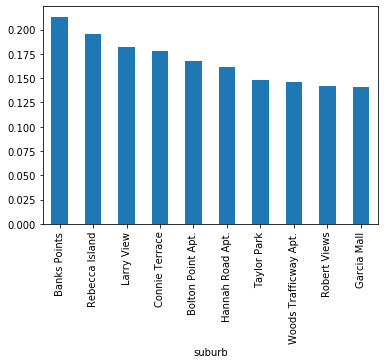

In [32]:
by_suburb.head(10).fraud_ratio.plot.bar()
plt.show()
# top 10 fradulent suburbs

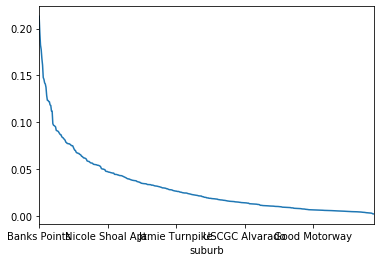

In [33]:
# some suburbs are more likely to produce frauds 
# the fraud ratio varis a lot across differen suburbs, 
# making suburb a good predictor
by_suburb.fraud_ratio.plot()

In [34]:
# then we invistigate different platforms 
by_platform = final[['platform','label']].groupby("platform").agg(['sum','count'])
by_platform['fraud_ratio'] = by_platform["label","sum"] / by_platform["label","count"]
by_platform = by_platform.sort_values(by ='fraud_ratio' ,ascending = False)
by_platform
# as we can see, claims coming from mobile apps are more
# end up being frauds, while phone calls are never fradulent 

label         fraud_ratio
                 sum   count            
platform                                
mobile_app      2066  112977    0.018287
pc_browser      5278  338839    0.015577
mobile_browser  3150  251879    0.012506
phone_call         0  120309    0.000000

In [35]:
# we can look at gender distribution as well
by_gender = final[['gender','label']].groupby("gender").agg(['sum','count'])
by_gender['fraud_ratio'] = by_gender["label","sum"] / by_gender["label","count"]
by_gender = by_gender.sort_values(by ='fraud_ratio' ,ascending = False)
by_gender
# there isn't distinct difference when it comes to gender 
# we can conduct statistical test to validate these results

label         fraud_ratio
         sum   count            
gender                          
female  5267  410077    0.012844
male    5227  413927    0.012628

In [36]:
X = final.drop("label", axis =1 )
Y = final.label

X.gender = X.gender.map({"male":1,"female":0})
le = preprocessing.LabelEncoder()
le.fit(X.suburb.unique().tolist()) # taking all the suburbs 
X.suburb = le.transform(X.suburb)

le_plat = preprocessing.LabelEncoder()
le_plat.fit(X.platform.unique().tolist()) 
X.platform = le_plat.transform(X.platform)



X=X[['matched_payment_complete','suburb','times_denid']]
# del X['platform_y']
# del X['case']
# del X['email']
# del X['street']
# del X['household']
# del X['name']
# del X['customer_id']



# categorial variables 


X.head()

,matched_payment_complete,suburb,times_denid
0,1,325,1
1,1,189,0
2,1,453,1
3,1,297,1
4,1,288,1


In [37]:
mid = int(X.shape[0]*0.8)
X_train = X[:mid]
Y_train = Y[:mid]

X_test = X[mid:]
Y_test = Y[mid:]

# simple decision tree
clf = DecisionTreeClassifier(random_state=2 )
#                              ,max_features=3,max_depth=3)
clf.fit(X_train, Y_train)

pred_label = pd.Series(clf.predict(X_test))
y_test = pd.Series(Y_test.tolist())

# True Negative rate on test:  TN / N
TN = ((y_test == pred_label)&(y_test==0) ).sum()
TP = ((y_test == pred_label)&(y_test==1) ).sum()

TNR = TN / (len(Y_test)- Y_test.sum())
TPR = TP/ Y_test.sum()

FP = ((y_test != pred_label)&(y_test==0) ).sum()
print("False Positives: {:.5f} normal people misclassified as frauds".format(FP))

print("True Negative rate on test: {:.6f}".format(TNR))
# print("True Positives: {:.5f}".format(TP))
print("True Positive rate on test: {:.6f}".format(TPR))

False Positives: 0.00000 normal people misclassified as frauds
True Negative rate on test: 1.000000
True Positive rate on test: 1.000000


In [38]:
clf.feature_importances_

array([0.02420439, 0.        , 0.97579561])

In [39]:
a= len(final[(final.matched_payment_complete==1)&(final.times_denid>0)&(final.label==1)]) 
b= len(final[(final.times_denid>0)&(final.matched_payment_complete==1)])
a/b

1.0

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pylab as plt
%matplotlib inline

In [41]:
#  Considering the new customers
final_2 = final.copy()
del final_2['case']
del final_2['times_denid']
del final_2['timeStamp']
del final_2['customer_id']
del final_2['street']
del final_2['email']
del final_2['name']
del final_2['platform_y']

del final_2['household'] # expecting to get more information outta here later!!!!
final_2.drop_duplicates(inplace=True)
X_ = final_2.drop("label", axis =1 )
Y_ = final_2.label
X_.gender = X_.gender.map({"male":1,"female":0})
le = preprocessing.LabelEncoder()
le.fit(X_.suburb.unique().tolist()) # taking all the suburbs 
X_.suburb = le.transform(X_.suburb)
le_plat = preprocessing.LabelEncoder()
le_plat.fit(X_.platform.unique().tolist()) 
X_.platform = le_plat.transform(X_.platform)

mid = int(X_.shape[0]*0.8)
X_train_ = X_[:mid]
Y_train_ = Y_[:mid]

X_test_ = X_[mid:]
Y_test_ = Y_[mid:]

In [107]:
# search for the best number of trees within a random forest
param_test1 = {
    'n_estimators':range(1,11)
}

clf = RandomForestClassifier(random_state=100)
grid_1 = GridSearchCV(clf, param_test1, cv=5, scoring='roc_auc')
grid_1.fit(X_train_,Y_train_)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

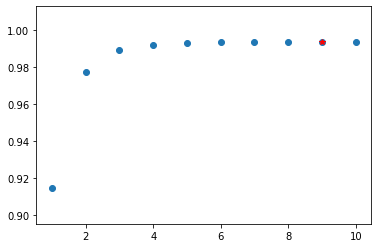

In [108]:
x = range(1,11)
y = grid_1.cv_results_['mean_test_score']
# plt.plot(x,y)
plt.scatter(x,y)
plt.plot(x[8], y[8], 'r*')

In [109]:
grid_1.best_params_

{'n_estimators': 9}

The search result indicates that growing 9 decision trees in one RF is optimal on this dataset
Then we conduct a grid search for the parameter combination max_depth and max_features. 

In [110]:
param_test2 = {'max_depth':range(3,14,2), 
               'max_features':range(3,10)
              }
clf = RandomForestClassifier(random_state=100, n_estimators = 9)
grid_2 = GridSearchCV(clf, param_test2, cv=5, scoring='roc_auc',return_train_score=False)
grid_2.fit(X_train_,Y_train_)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(3, 14, 2), 'max_features': range(3, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

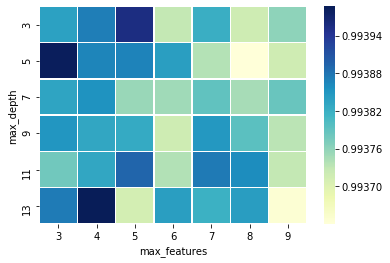

In [111]:
Index = list(range(3,14,2))
Cols = list(range(3,10))
df = pd.DataFrame(grid_2.cv_results_["mean_test_score"].reshape((6,7)), index=Index, columns=Cols)
sns.heatmap(df,linewidths=.5,cmap="YlGnBu")
plt.xlabel('max_features')
plt.ylabel('max_depth')
plt.show()

In [112]:
grid_2.best_params_

{'max_depth': 13, 'max_features': 4}

In [113]:
# taking the optimal parameter combinations, train a model and examine results in test set
clf = RandomForestClassifier(random_state=100, n_estimators = 9,max_depth=13,max_features=4)

clf.fit(X_train_, Y_train_)

pred_label = pd.Series(clf.predict(X_test_))
y_test_ = pd.Series(Y_test_.tolist())

# True Negative rate on test:  TN / N
TN = ((y_test_ == pred_label)&(y_test_==0) ).sum()
TP = ((y_test_ == pred_label)&(y_test_==1) ).sum()

TNR = TN / (len(Y_test_)- Y_test_.sum())
TPR = TP/ Y_test_.sum()

FP = ((y_test_ != pred_label)&(y_test_==0) ).sum()
print("False Positives: {:.5f} normal people misclassified as frauds".format(FP))

print("True Negative rate on test: {:.6f}".format(TNR))
# print("True Positives: {:.5f}".format(TP))
print("True Positive rate on test: {:.6f}".format(TPR))

False Positives: 345.00000 normal people misclassified as frauds
True Negative rate on test: 0.989106
True Positive rate on test: 0.998472


In [114]:
clf.feature_importances_

array([0.00671   , 0.94416667, 0.0014009 , 0.01004661, 0.00096032,
       0.0176523 , 0.00334214, 0.        , 0.01572107])

In [51]:
X_train_.columns

Index(['platform', 'matched_payment_complete', 'gender', 'age', 'home_type',
       'square_footage', 'number_of_bedrooms', 'number_of_floors', 'suburb'],
      dtype='object')

In [120]:
# final[final.label==0]